In [1]:
#libraries
from scipy import stats
import pandas as pd
import numpy as np
from numpy import arange
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_predict,cross_val_score, RepeatedKFold
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn import datasets, linear_model
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import classification_report, mean_squared_error
#from regressors import stats 
from gplearn.genetic import SymbolicRegressor
from sympy import *
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import math
import statsmodels.formula.api as smf 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
Data = pd.read_csv("Project1_Dataset/airfoil_self_noise.csv")
Data.head()

,Frequency,AngleOfAttack,ChordLength,FreeStreamVelocity,SuctionSideDisplacementThickness,Scaled sound pressure level
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


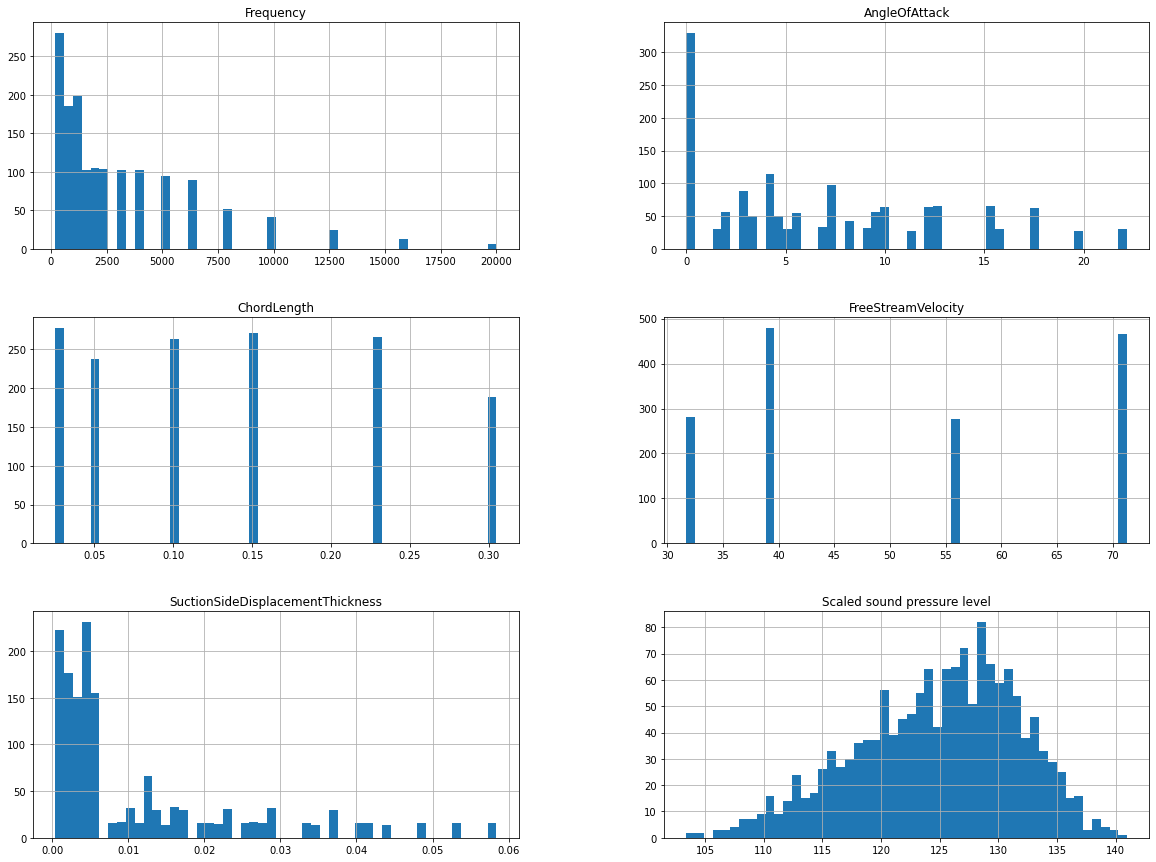

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
Data.hist(bins=50, figsize=(20,15))
plt.show()

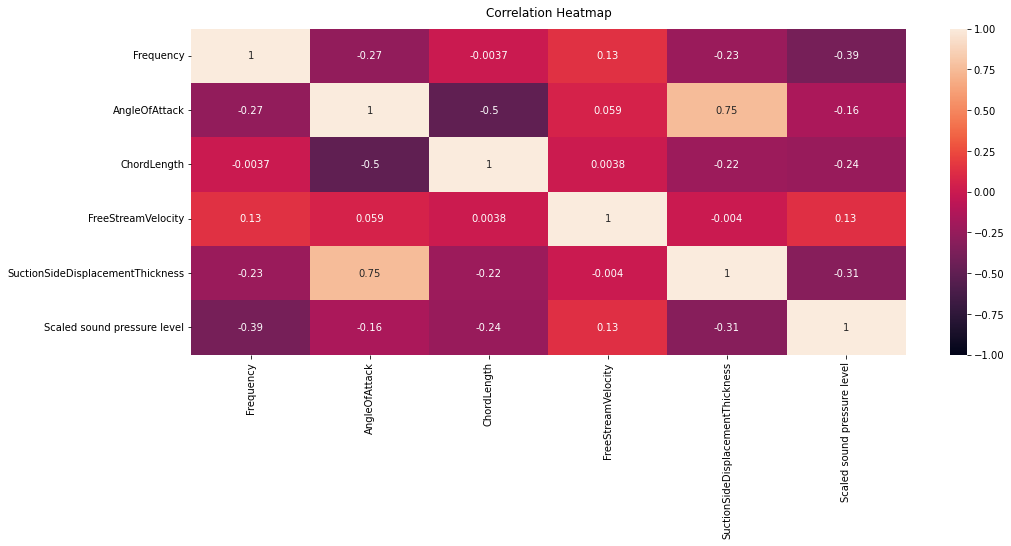

In [4]:
import seaborn as sns

# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))

# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(Data.corr(), vmin=-1, vmax=1, annot=True)

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [5]:
#changing from type object to type float
for x in range(6):
    Data.iloc[:,x] = Data.iloc[:,x].astype(float)
Data.describe().round(2)

,Frequency,AngleOfAttack,ChordLength,FreeStreamVelocity,SuctionSideDisplacementThickness,Scaled sound pressure level
count,1503.00,1503.00,1503.00,1503.00,1503.00,1503.00
mean,2886.38,6.78,0.14,50.86,0.01,124.84
std,3152.57,5.92,0.09,15.57,0.01,6.90
min,200.00,0.00,0.03,31.70,0.00,103.38
25%,800.00,2.00,0.05,39.60,0.00,120.19
50%,1600.00,5.40,0.10,39.60,0.00,125.72
75%,4000.00,9.90,0.23,71.30,0.02,130.00
max,20000.00,22.20,0.30,71.30,0.06,140.99


In [6]:
# Splitting the data

x = Data[["Frequency", "AngleOfAttack", "ChordLength","FreeStreamVelocity", "SuctionSideDisplacementThickness"]]
y = Data[["Scaled sound pressure level"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [7]:
Data.sample(10)

,Frequency,AngleOfAttack,ChordLength,FreeStreamVelocity,SuctionSideDisplacementThickness,Scaled sound pressure level
930,3150.0,15.4,0.0508,31.7,0.028985,118.045
230,400.0,0.0,0.2286,31.7,0.002724,123.635
1413,500.0,12.3,0.1016,71.3,0.033779,140.158
581,6300.0,5.4,0.1524,39.6,0.004850,116.677
633,500.0,9.9,0.1524,71.3,0.019300,131.279
828,3150.0,8.4,0.0508,39.6,0.005662,123.965
1105,1250.0,9.5,0.0254,31.7,0.004614,131.446
434,3150.0,7.3,0.2286,39.6,0.012348,114.309
63,6300.0,0.0,0.3048,31.7,0.003313,113.775
403,4000.0,7.3,0.2286,71.3,0.010440,119.208


# R2 and Adj R2 calculated and plotted against combinations of features

In [8]:
NUM_FEATURES = ["Frequency", "AngleOfAttack", "ChordLength","FreeStreamVelocity", "SuctionSideDisplacementThickness"]
                
num_pipe = Pipeline(steps=[
    ('scale', StandardScaler()),   
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, NUM_FEATURES),
], remainder='drop')


rCVscores=[] 
r2scores =[]
adjustedr2 = []
feature_names=[]
for i in range(1, 6):   
    reduce_dim_pipe = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('reduce_dim', SelectKBest(k=i, score_func=f_regression)),       
    ])
    
    pipeline = Pipeline(steps=[
        ('reduce_dim_pipe', reduce_dim_pipe),       
        ('regress', LinearRegression())
    ])
    
    
    #calculate cross validated R2
    R2 = cross_val_score(pipeline, X=x_train, y=y_train,cv=5, scoring='r2').mean()    
    rCVscores.append(R2)
    
    predicted = cross_val_predict(pipeline,X=x_train, y=y_train, cv=5) 
    r2=r2_score(y_train, predicted)
    r2scores.append(r2)
        
    #calculate Adj R2
    n= len(x_train)
    p = i
    adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1)) #Adj R2 = 1-(1-R2)*(n-1)/(n-p-1)
    adjustedr2.append(adj_R2)
    
    reduce_dim_pipe.fit(X=x_train, y=y_train)
    # Get columns to keep    
    cols = reduce_dim_pipe.named_steps['reduce_dim'].get_support(indices=True)
    # Create new dataframe with only desired columns
    features_df_new = x_train.iloc[:, cols]
    best_features = list(features_df_new.columns)
    feature_names.append(best_features)

C:\Users\kllee\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kllee\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kllee\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kllee\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\kllee\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kllee\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kllee\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kllee\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

In [9]:
scoring_df = pd.DataFrame(np.column_stack((rCVscores,r2scores, adjustedr2)), columns=['R2CV','R2', 'Adj_R2']) 
scoring_df['feature_names'] = feature_names
scoring_df['features'] = range(1, 6)
scoring_df

,R2CV,R2,Adj_R2,feature_names,features
0,0.144304,0.149466,0.148757,[Frequency],1
1,0.297368,0.302855,0.301692,"[Frequency, SuctionSideDisplacementThickness]",2
2,0.411952,0.416610,0.415149,"[Frequency, ChordLength, SuctionSideDisplaceme...",3
3,0.444153,0.449072,0.447231,"[Frequency, AngleOfAttack, ChordLength, Suctio...",4
4,0.491834,0.495907,0.493800,"[Frequency, AngleOfAttack, ChordLength, FreeSt...",5


Text(0.5, 1.0, 'Plot between number of features and R2CV/R2/Adj R2 scores')

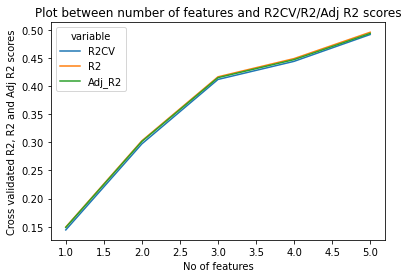

In [10]:
fig, ax = plt.subplots(figsize=(6, 4)) 
long_format_df = pd.melt(scoring_df.loc[:, ['features','R2CV','R2', 'Adj_R2']], ['features'])
sns.lineplot(x='features', y='value', hue='variable', data=long_format_df, ax=ax)
ax.set_xlabel('No of features')
ax.set_ylabel('Cross validated R2, R2 and Adj R2 scores')
ax.set_title('Plot between number of features and R2CV/R2/Adj R2 scores')

# Linear Regression

In [11]:
#adding in intercept
Data.insert(0, "intercept", 1)
Data.head()

,intercept,Frequency,AngleOfAttack,ChordLength,FreeStreamVelocity,SuctionSideDisplacementThickness,Scaled sound pressure level
0,1,800.0,0.0,0.3048,71.3,0.002663,126.201
1,1,1000.0,0.0,0.3048,71.3,0.002663,125.201
2,1,1250.0,0.0,0.3048,71.3,0.002663,125.951
3,1,1600.0,0.0,0.3048,71.3,0.002663,127.591
4,1,2000.0,0.0,0.3048,71.3,0.002663,127.461


In [12]:
# Splitting the data for linear w/ intercept
x = Data[["intercept", "Frequency", "AngleOfAttack", "ChordLength","FreeStreamVelocity", "SuctionSideDisplacementThickness"]]
y = Data[["Scaled sound pressure level"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [13]:
# Linear Regression using statmodels since scikit doesn't produce summary table like below
LMModel = sm.OLS(y_train, x_train).fit()
LMModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     Scaled sound pressure level   R-squared:                       0.514
Model:                                     OLS   Adj. R-squared:                  0.512
Method:                          Least Squares   F-statistic:                     253.3
Date:                         Sun, 19 Feb 2023   Prob (F-statistic):          1.10e-184
Time:                                 18:43:45   Log-Likelihood:                -3598.9
No. Observations:                         1202   AIC:                             7210.
Df Residuals:                             1196   BIC:                             7240.
Df Model:                                    5                                         
Covariance Type:                     nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
intercept                          132.6757      0.621    213.662      0.000     131.457     133.894
Frequency                           -0.0013   4.83e-05    -26.944      0.000      -0.001      -0.001
AngleOfAttack                       -0.4126      0.044     -9.369      0.000      -0.499      -0.326
ChordLength                        -36.0382      1.852    -19.459      0.000     -39.672     -32.405
FreeStreamVelocity                   0.1064      0.009     11.670      0.000       0.088       0.124
SuctionSideDisplacementThickness  -151.1045     16.851     -8.967      0.000    -184.165    -118.044
==============================================================================
Omnibus:                        6.800   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                8.609
Skew:                          -0.046   Prob(JB):                       0.0135
Kurtosis:                       3.404   Cond. No.                     5.07e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.07e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Feature Selection using Sequential Forward, backward and stepwise techniques

In [14]:
# Sequential Forward Selection(sfs)
sfs = sfs(LinearRegression(),
          k_features=3,
          forward=True,
          floating=False,
          scoring = 'r2',
          cv = 5)
sfs.fit(x, y)
sfs.k_feature_names_  

('Frequency', 'ChordLength', 'SuctionSideDisplacementThickness')

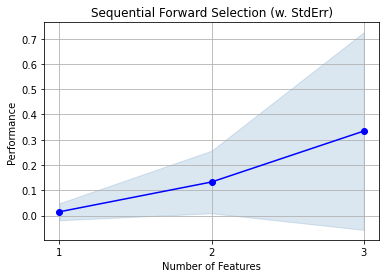

In [15]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [16]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
#Sequential backward selection(sbs)
sbs = sfs(LinearRegression(),
         k_features=3,
         forward=False,
         floating=False,
         cv=5)
sbs.fit(x, y)
sbs.k_feature_names_

('Frequency', 'AngleOfAttack', 'ChordLength')

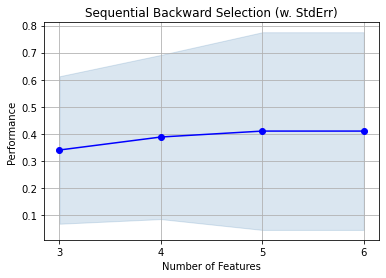

In [17]:
fig2 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Backward Selection (w. StdErr)')
plt.grid()
plt.show()

In [18]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
# Sequential Forward Floating Selection(sffs) stepwise
sffs = sfs(LinearRegression(),
         k_features=(1, 5),
         forward=True,
         floating=True,
         cv=5)
sffs.fit(x, y)
sffs.k_feature_names_

('Frequency',
 'AngleOfAttack',
 'ChordLength',
 'FreeStreamVelocity',
 'SuctionSideDisplacementThickness')

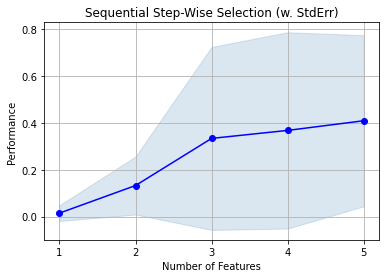

In [19]:
fig3 = plot_sfs(sffs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Step-Wise Selection (w. StdErr)')
plt.grid()
plt.show()

eval_env: 1


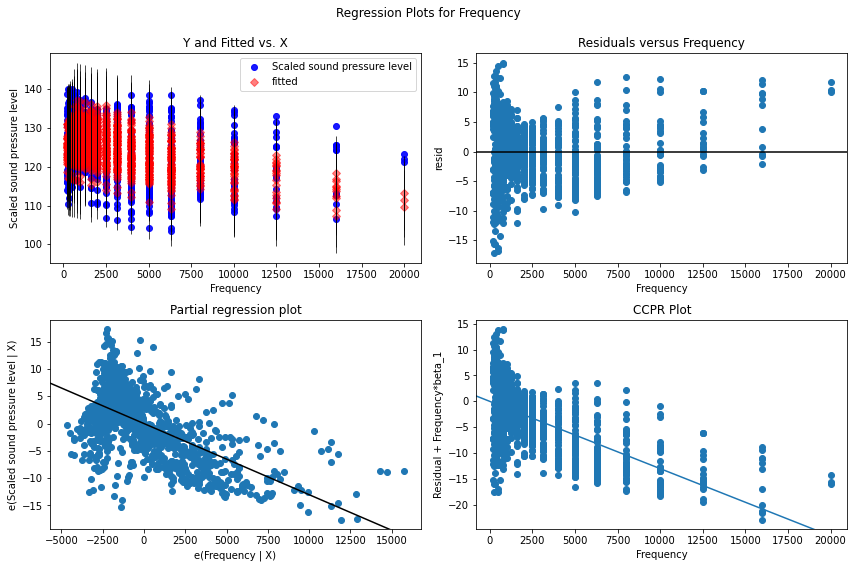

In [20]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(LMModel, "Frequency", fig=fig)

eval_env: 1


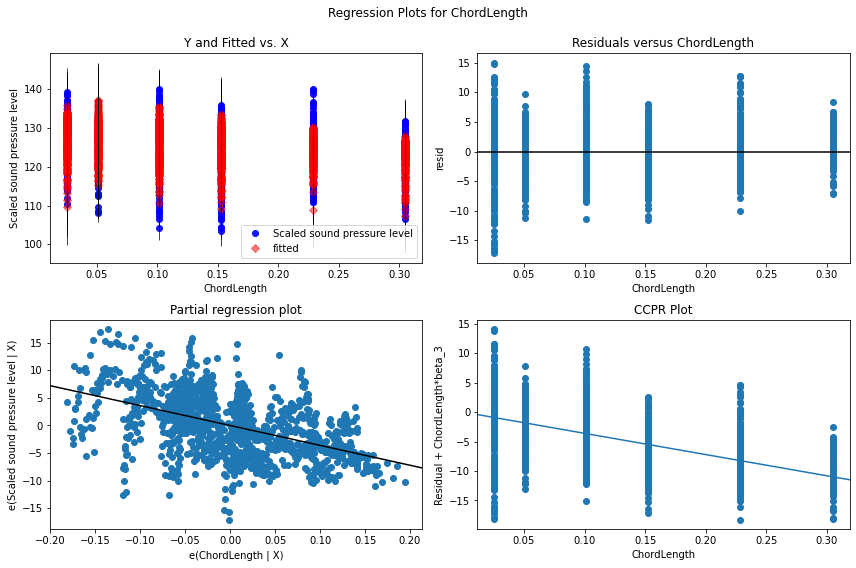

In [21]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(LMModel, "ChordLength", fig=fig)

eval_env: 1


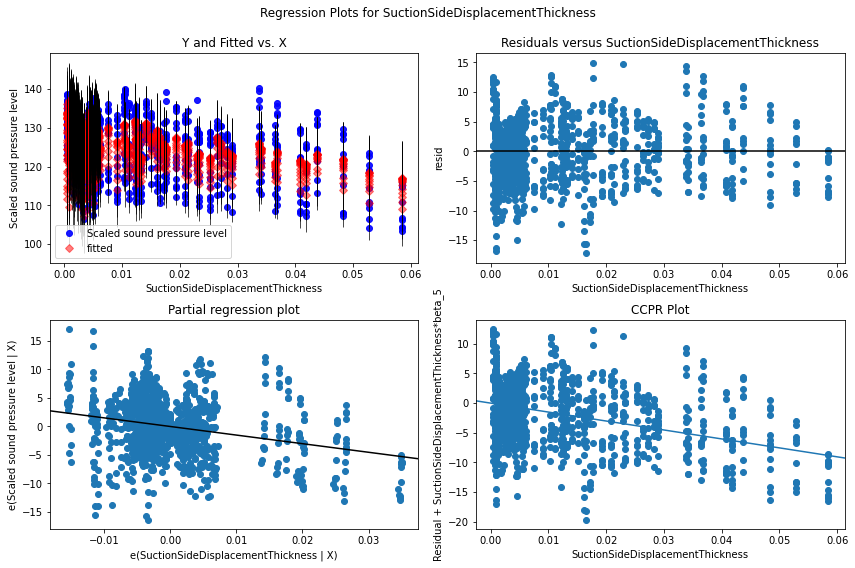

In [22]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(LMModel, "SuctionSideDisplacementThickness", fig=fig)

## Linear Regression Summary Stat & Cross Validation

In [23]:
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils.validation import check_X_y, check_is_fitted, check_array
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.estimator_checks import check_estimator

class MyLinearRegression(BaseEstimator, RegressorMixin):
    def __init__(self, fit_intercept=True):

        self.fit_intercept = fit_intercept

    def fit(self, X, y, column_names=() ):

        if self.fit_intercept:
            X = sm.add_constant(X)

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        self.X_ = X
        self.y_ = y

        if len(column_names) != 0:
            cols = column_names.copy()
            cols = list(cols)
            X = pd.DataFrame(X)
            cols = column_names.copy()
            cols.insert(0,'intercept')
            print('X ', X)
            X.columns = cols

        self.model_ = sm.OLS(y, X)
        self.results_ = self.model_.fit()
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, 'model_')

        # Input validation
        X = check_array(X)

        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

    def get_params(self, deep = False):
        return {'fit_intercept':self.fit_intercept}


    def summary(self):
        print(self.results_.summary() )

        

In [24]:
cols =["Frequency", "AngleOfAttack", "ChordLength","FreeStreamVelocity", "SuctionSideDisplacementThickness"]

X_train = x_train[cols].values
X_test = x_test[cols].values
Y_train = y_train["Scaled sound pressure level"]
Y_test = y_test["Scaled sound pressure level"]
model = MyLinearRegression()
model.fit(X_train, Y_train)
model.summary()

# Compare predicted values with actual values
Predictions = pd.DataFrame()
Predictions['Linear Regression'] = LMPred = model.predict(X_test)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     253.3
Date:                Sun, 19 Feb 2023   Prob (F-statistic):          1.10e-184
Time:                        18:43:59   Log-Likelihood:                -3598.9
No. Observations:                1202   AIC:                             7210.
Df Residuals:                    1196   BIC:                             7240.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        132.6757      0.621    213.662      0.0

In [25]:
R_Squared_CV = []
from sklearn.model_selection import cross_val_score
scores = cross_val_score(MyLinearRegression(), X_train, Y_train, cv=7, scoring='r2')
scores

array([0.41972021, 0.46683294, 0.56261612, 0.45677664, 0.60544053,
       0.48877738, 0.5363738 ])

In [26]:
# Create an array that contains RMSE for all the models
ModelNames = ['Linear Reg']
RMSE = mean_squared_error(Y_test, LMPred, squared = False)

# Transformed Regression

### Square Root

In [27]:
import math

NewY = y["Scaled sound pressure level"].apply(lambda x:math.sqrt(x))
X_train, X_test, Y_train, Y_test = train_test_split(x, NewY, test_size = 0.2, random_state = 2)

In [28]:
# Transformed Regression 
TRModel = sm.OLS(Y_train, X_train).fit()
TRModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     Scaled sound pressure level   R-squared:                       0.521
Model:                                     OLS   Adj. R-squared:                  0.519
Method:                          Least Squares   F-statistic:                     260.1
Date:                         Sun, 19 Feb 2023   Prob (F-statistic):          3.25e-188
Time:                                 18:43:59   Log-Likelihood:                 155.22
No. Observations:                         1202   AIC:                            -298.4
Df Residuals:                             1196   BIC:                            -267.9
Df Model:                                    5                                         
Covariance Type:                     nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
intercept                           11.5182      0.027    425.561      0.000      11.465      11.571
Frequency                        -5.817e-05   2.11e-06    -27.573      0.000   -6.23e-05    -5.4e-05
AngleOfAttack                       -0.0187      0.002     -9.527      0.000      -0.023      -0.015
ChordLength                         -1.5515      0.081    -19.243      0.000      -1.710      -1.393
FreeStreamVelocity                   0.0046      0.000     11.348      0.000       0.004       0.005
SuctionSideDisplacementThickness    -6.6575      0.748     -8.899      0.000      -8.125      -5.190
==============================================================================
Omnibus:                        5.113   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.078   Jarque-Bera (JB):                6.243
Skew:                          -0.005   Prob(JB):                       0.0441
Kurtosis:                       3.353   Cond. No.                     5.11e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
Predictions['Transformed Regression: sqrt'] = TRPred = TRModel.predict(X_test).apply(lambda x:(x**2)).to_numpy()

### Quadratic

In [30]:
QuadY = y["Scaled sound pressure level"].apply(lambda x:(x**2))

X_train, X_test, Y_train, Y_test = train_test_split(x, QuadY, test_size = 0.2, random_state = 2)

In [31]:
TRModelQuad = sm.OLS(Y_train, X_train).fit()
TRModelQuad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     Scaled sound pressure level   R-squared:                       0.507
Model:                                     OLS   Adj. R-squared:                  0.505
Method:                          Least Squares   F-statistic:                     246.1
Date:                         Sun, 19 Feb 2023   Prob (F-statistic):          7.49e-181
Time:                                 18:43:59   Log-Likelihood:                -10211.
No. Observations:                         1202   AIC:                         2.043e+04
Df Residuals:                             1196   BIC:                         2.046e+04
Df Model:                                    5                                         
Covariance Type:                     nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
intercept                         1.752e+04    150.578    116.367      0.000    1.72e+04    1.78e+04
Frequency                           -0.3131      0.012    -26.679      0.000      -0.336      -0.290
AngleOfAttack                     -104.6891     10.899     -9.606      0.000    -126.072     -83.306
ChordLength                      -8572.7643    448.554    -19.112      0.000   -9452.805   -7692.723
FreeStreamVelocity                  25.2739      2.242     11.275      0.000      20.876      29.672
SuctionSideDisplacementThickness -3.448e+04   4162.211     -8.285      0.000   -4.27e+04   -2.63e+04
==============================================================================
Omnibus:                        9.733   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               11.900
Skew:                           0.117   Prob(JB):                      0.00261
Kurtosis:                       3.428   Cond. No.                     5.11e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Cubic

In [32]:
CubeY = y["Scaled sound pressure level"].apply(lambda x:(x**3))

X_train, X_test, Y_train, Y_test = train_test_split(x, CubeY, test_size = 0.2, random_state = 2)

In [33]:
TRModelCube = sm.OLS(Y_train, X_train).fit()
TRModelCube.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     Scaled sound pressure level   R-squared:                       0.497
Model:                                     OLS   Adj. R-squared:                  0.495
Method:                          Least Squares   F-statistic:                     236.1
Date:                         Sun, 19 Feb 2023   Prob (F-statistic):          1.75e-175
Time:                                 18:43:59   Log-Likelihood:                -16505.
No. Observations:                         1202   AIC:                         3.302e+04
Df Residuals:                             1196   BIC:                         3.305e+04
Df Model:                                    5                                         
Covariance Type:                     nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
intercept                         2.311e+06   2.83e+04     81.651      0.000    2.26e+06    2.37e+06
Frequency                          -57.4267      2.206    -26.033      0.000     -61.755     -53.099
AngleOfAttack                    -1.969e+04   2048.364     -9.614      0.000   -2.37e+04   -1.57e+04
ChordLength                      -1.599e+06   8.43e+04    -18.970      0.000   -1.76e+06   -1.43e+06
FreeStreamVelocity                4720.4473    421.286     11.205      0.000    3893.906    5546.988
SuctionSideDisplacementThickness  -6.17e+06   7.82e+05     -7.887      0.000    -7.7e+06   -4.63e+06
==============================================================================
Omnibus:                       17.555   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.586
Skew:                           0.202   Prob(JB):                     2.05e-05
Kurtosis:                       3.517   Cond. No.                     5.11e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Symbolic Regression

In [34]:
# First Test
function_set = ['add', 'sub', 'mul', 'div','neg','inv']
SRModel = SymbolicRegressor(population_size=5000,function_set=function_set,
                           generations=20, metric='mse', stopping_criteria=18.214676,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0,
                          feature_names=x_train.columns)
SRModel.fit(x_train, y_train)



C:\Users\kllee\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    15.07      9.20412e+26       26          1215.39          1266.91      4.07m
   1    10.00      1.41524e+15       26          1098.59          1107.63      3.91m
   2    10.90      3.62849e+15       15          951.171          969.283      3.29m
   3    14.75      1.23884e+15       25          843.738          822.556      3.86m
   4    20.44      7.41753e+12       25          738.937          816.264      3.93m
   5    24.35      1.46499e+15       27          402.994          371.301      4.48m
   6    24.92      8.70513e+19       16          259.203          238.695      3.59m
   7    25.95      2.46392e+17       29          222.069          207.883      3.28m
   8    26.41      1.98543e+13       22          217.048          245.712  

SymbolicRegressor(feature_names=Index(['intercept', 'Frequency', 'AngleOfAttack', 'ChordLength',
       'FreeStreamVelocity', 'SuctionSideDisplacementThickness'],
      dtype='object'),
                  function_set=['add', 'sub', 'mul', 'div', 'neg', 'inv'],
                  max_samples=0.9, metric='mse', p_crossover=0.7,
                  p_hoist_mutation=0.05, p_point_mutation=0.1,
                  p_subtree_mutation=0.1, parsimony_coefficient=0.01,
                  population_size=5000, random_state=0,
                  stopping_criteria=18.214676, verbose=1)

In [35]:
print('r_squared:',SRModel.score(x_test,y_test))
print(f'Adj_R-Squared: {1 - (1-SRModel.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)}')

r_squared: -0.07614221135123334
Adj_R-Squared: -0.09810429729717685


In [36]:
#Visualising the symbolic function

converter = {
    'sub': lambda x, y : x - y,
    'div': lambda x, y : x/y,
    'mul': lambda x, y : x*y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : -x,
    'pow': lambda x, y : x**y,
    'inv': lambda x: 1/x,
    'sqrt': lambda x: x**0.5,
    'pow3': lambda x: x**3
}

SymbolicEqn = sympify(str(SRModel._program), locals=converter)
SymbolicEqn

(-26.3157894736842*ChordLength + FreeStreamVelocity + 0.178*(0.126 - FreeStreamVelocity)*(SuctionSideDisplacementThickness - 0.624) + 43.1168418947368)*(ChordLength + FreeStreamVelocity - SuctionSideDisplacementThickness + 79.1253684210526)/(2*FreeStreamVelocity)

In [37]:
#Add Symbolic Regression Predicted Values
y_pred = Predictions['Symbolic Regression'] = SRPred = SRModel.predict(x_test)

In [38]:
# Append RMSE for all the models
ModelNames.append('Symbolic Reg')

# Add RMSE
RMSE = np.append(RMSE, mean_squared_error(y_test, SRPred, squared = False))

# Ridge Regression

In [39]:
#removing intercept
Data.drop(columns=['intercept'], inplace=True)

In [40]:
# Splitting the data
x = Data[["Frequency", "AngleOfAttack", "ChordLength","FreeStreamVelocity", "SuctionSideDisplacementThickness"]]
y = Data[["Scaled sound pressure level"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [41]:
pipeline = Pipeline([
                     ('model',Ridge())
])
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.01,10,0.1)},
                      cv = 5, scoring="r2",verbose=3
                      )
search.fit(x_train,y_train)
#return best alpha value
search.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END .................model__alpha=0.01;, score=0.486 total time=   0.0s
[CV 2/5] END .................model__alpha=0.01;, score=0.509 total time=   0.0s
[CV 3/5] END .................model__alpha=0.01;, score=0.484 total time=   0.0s
[CV 4/5] END .................model__alpha=0.01;, score=0.585 total time=   0.0s
[CV 5/5] END .................model__alpha=0.01;, score=0.441 total time=   0.0s
[CV 1/5] END .................model__alpha=0.11;, score=0.474 total time=   0.0s
[CV 2/5] END .................model__alpha=0.11;, score=0.489 total time=   0.0s
[CV 3/5] END .................model__alpha=0.11;, score=0.460 total time=   0.0s
[CV 4/5] END .................model__alpha=0.11;, score=0.580 total time=   0.0s
[CV 5/5] END .................model__alpha=0.11;, score=0.456 total time=   0.0s
[CV 1/5] END ..model__alpha=0.21000000000000002;, score=0.468 total time=   0.0s
[CV 2/5] END ..model__alpha=0.2100000000000000

[CV 4/5] END .................model__alpha=2.11;, score=0.550 total time=   0.0s
[CV 5/5] END .................model__alpha=2.11;, score=0.448 total time=   0.0s
[CV 1/5] END .................model__alpha=2.21;, score=0.443 total time=   0.0s
[CV 2/5] END .................model__alpha=2.21;, score=0.448 total time=   0.0s
[CV 3/5] END .................model__alpha=2.21;, score=0.427 total time=   0.0s
[CV 4/5] END .................model__alpha=2.21;, score=0.549 total time=   0.0s
[CV 5/5] END .................model__alpha=2.21;, score=0.447 total time=   0.0s
[CV 1/5] END .................model__alpha=2.31;, score=0.442 total time=   0.0s
[CV 2/5] END .................model__alpha=2.31;, score=0.446 total time=   0.0s
[CV 3/5] END .................model__alpha=2.31;, score=0.426 total time=   0.0s
[CV 4/5] END .................model__alpha=2.31;, score=0.547 total time=   0.0s
[CV 5/5] END .................model__alpha=2.31;, score=0.447 total time=   0.0s
[CV 1/5] END ...............

[CV 2/5] END .................model__alpha=4.41;, score=0.418 total time=   0.0s
[CV 3/5] END .................model__alpha=4.41;, score=0.406 total time=   0.0s
[CV 4/5] END .................model__alpha=4.41;, score=0.522 total time=   0.0s
[CV 5/5] END .................model__alpha=4.41;, score=0.430 total time=   0.0s
[CV 1/5] END .................model__alpha=4.51;, score=0.420 total time=   0.0s
[CV 2/5] END .................model__alpha=4.51;, score=0.417 total time=   0.0s
[CV 3/5] END .................model__alpha=4.51;, score=0.405 total time=   0.0s
[CV 4/5] END .................model__alpha=4.51;, score=0.521 total time=   0.0s
[CV 5/5] END .................model__alpha=4.51;, score=0.429 total time=   0.0s
[CV 1/5] END .................model__alpha=4.61;, score=0.420 total time=   0.0s
[CV 2/5] END .................model__alpha=4.61;, score=0.416 total time=   0.0s
[CV 3/5] END .................model__alpha=4.61;, score=0.404 total time=   0.0s
[CV 4/5] END ...............

[CV 2/5] END ...model__alpha=6.8100000000000005;, score=0.391 total time=   0.0s
[CV 3/5] END ...model__alpha=6.8100000000000005;, score=0.384 total time=   0.0s
[CV 4/5] END ...model__alpha=6.8100000000000005;, score=0.498 total time=   0.0s
[CV 5/5] END ...model__alpha=6.8100000000000005;, score=0.411 total time=   0.0s
[CV 1/5] END .................model__alpha=6.91;, score=0.400 total time=   0.0s
[CV 2/5] END .................model__alpha=6.91;, score=0.390 total time=   0.0s
[CV 3/5] END .................model__alpha=6.91;, score=0.383 total time=   0.0s
[CV 4/5] END .................model__alpha=6.91;, score=0.497 total time=   0.0s
[CV 5/5] END .................model__alpha=6.91;, score=0.410 total time=   0.0s
[CV 1/5] END .................model__alpha=7.01;, score=0.400 total time=   0.0s
[CV 2/5] END .................model__alpha=7.01;, score=0.389 total time=   0.0s
[CV 3/5] END .................model__alpha=7.01;, score=0.382 total time=   0.0s
[CV 4/5] END ...............

[CV 1/5] END .................model__alpha=9.21;, score=0.385 total time=   0.0s
[CV 2/5] END .................model__alpha=9.21;, score=0.369 total time=   0.0s
[CV 3/5] END .................model__alpha=9.21;, score=0.366 total time=   0.0s
[CV 4/5] END .................model__alpha=9.21;, score=0.478 total time=   0.0s
[CV 5/5] END .................model__alpha=9.21;, score=0.395 total time=   0.0s
[CV 1/5] END .................model__alpha=9.31;, score=0.384 total time=   0.0s
[CV 2/5] END .................model__alpha=9.31;, score=0.368 total time=   0.0s
[CV 3/5] END .................model__alpha=9.31;, score=0.365 total time=   0.0s
[CV 4/5] END .................model__alpha=9.31;, score=0.478 total time=   0.0s
[CV 5/5] END .................model__alpha=9.31;, score=0.394 total time=   0.0s
[CV 1/5] END .................model__alpha=9.41;, score=0.383 total time=   0.0s
[CV 2/5] END .................model__alpha=9.41;, score=0.368 total time=   0.0s
[CV 3/5] END ...............

{'model__alpha': 0.01}

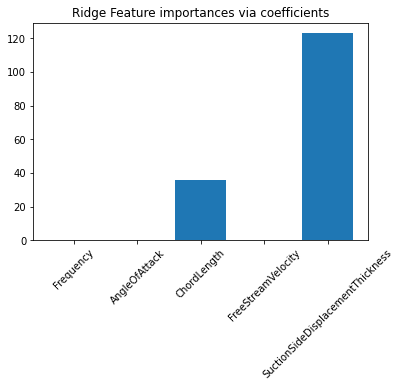

In [42]:
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)

fname = ["Frequency", "AngleOfAttack", "ChordLength","FreeStreamVelocity", "SuctionSideDisplacementThickness"]
feature_names = np.array(fname)
plt.bar(height=importance.reshape(5), x=feature_names)
plt.xticks(rotation = 45)
plt.title("Ridge Feature importances via coefficients")
plt.show()

In [43]:
#Ridge regression with built-in cross-validation
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

# define model, Flagging Alpha_per_Target to True indicating  to optimize the alpha value...after fitting, the alpha_ attribute will contain a value for each target.
model = RidgeCV(alphas=arange(0.01, 1, 0.01), cv=cv, scoring='r2')

# fit model
# fit model using importnt features 
x_trainrr = x_train[['SuctionSideDisplacementThickness','ChordLength','AngleOfAttack']].copy() 
x_testrr = x_test[['SuctionSideDisplacementThickness','ChordLength','AngleOfAttack']].copy()
RRModel = model.fit(x_trainrr, y_train)


# summarize chosen configuration
print('alpha_: %f' % model.alpha_)
print('r_squared: %f' % model.best_score_)

alpha_: 0.010000
r_squared: 0.174621


In [44]:
# Ridge Regression Coefficients
RRModel.coef_

array([[-136.95912054,  -25.76780018,   -0.16871591]])

In [45]:
#Add Ridge Regression Predicted Values
Predictions['Ridge Regression'] = RRPred = RRModel.predict(x_testrr)

In [46]:
# Append RMSE for all the models
ModelNames.append('Ridge Reg')

# Add RMSE
RMSE = np.append(RMSE,mean_squared_error(y_test, RRPred, squared = False))

# Lasso Regression

In [47]:
#Feature Importance using Lasso and gridsearchCV

pipeline = Pipeline([
                     ('model',Lasso())
])
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.01,10,0.1)},
                      cv = 5, scoring="r2",verbose=3
                      )
search.fit(x_train,y_train)
#The best value for α is:
search.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END .................model__alpha=0.01;, score=0.454 total time=   0.0s
[CV 2/5] END .................model__alpha=0.01;, score=0.465 total time=   0.0s
[CV 3/5] END .................model__alpha=0.01;, score=0.434 total time=   0.0s
[CV 4/5] END .................model__alpha=0.01;, score=0.571 total time=   0.0s
[CV 5/5] END .................model__alpha=0.01;, score=0.455 total time=   0.0s
[CV 1/5] END .................model__alpha=0.11;, score=0.417 total time=   0.0s
[CV 2/5] END .................model__alpha=0.11;, score=0.411 total time=   0.0s
[CV 3/5] END .................model__alpha=0.11;, score=0.402 total time=   0.0s
[CV 4/5] END .................model__alpha=0.11;, score=0.515 total time=   0.0s
[CV 5/5] END .................model__alpha=0.11;, score=0.428 total time=   0.0s
[CV 1/5] END ..model__alpha=0.21000000000000002;, score=0.321 total time=   0.0s
[CV 2/5] END ..model__alpha=0.2100000000000000

[CV 4/5] END .................model__alpha=2.21;, score=0.337 total time=   0.0s
[CV 5/5] END .................model__alpha=2.21;, score=0.252 total time=   0.0s
[CV 1/5] END .................model__alpha=2.31;, score=0.248 total time=   0.0s
[CV 2/5] END .................model__alpha=2.31;, score=0.204 total time=   0.0s
[CV 3/5] END .................model__alpha=2.31;, score=0.221 total time=   0.0s
[CV 4/5] END .................model__alpha=2.31;, score=0.336 total time=   0.0s
[CV 5/5] END .................model__alpha=2.31;, score=0.252 total time=   0.0s
[CV 1/5] END .................model__alpha=2.41;, score=0.247 total time=   0.0s
[CV 2/5] END .................model__alpha=2.41;, score=0.204 total time=   0.0s
[CV 3/5] END .................model__alpha=2.41;, score=0.221 total time=   0.0s
[CV 4/5] END .................model__alpha=2.41;, score=0.336 total time=   0.0s
[CV 5/5] END .................model__alpha=2.41;, score=0.251 total time=   0.0s
[CV 1/5] END ...............

[CV 2/5] END .................model__alpha=4.61;, score=0.193 total time=   0.0s
[CV 3/5] END .................model__alpha=4.61;, score=0.212 total time=   0.0s
[CV 4/5] END .................model__alpha=4.61;, score=0.327 total time=   0.0s
[CV 5/5] END .................model__alpha=4.61;, score=0.231 total time=   0.0s
[CV 1/5] END .................model__alpha=4.71;, score=0.230 total time=   0.0s
[CV 2/5] END .................model__alpha=4.71;, score=0.192 total time=   0.0s
[CV 3/5] END .................model__alpha=4.71;, score=0.211 total time=   0.0s
[CV 4/5] END .................model__alpha=4.71;, score=0.327 total time=   0.0s
[CV 5/5] END .................model__alpha=4.71;, score=0.230 total time=   0.0s
[CV 1/5] END ...model__alpha=4.8100000000000005;, score=0.229 total time=   0.0s
[CV 2/5] END ...model__alpha=4.8100000000000005;, score=0.192 total time=   0.0s
[CV 3/5] END ...model__alpha=4.8100000000000005;, score=0.211 total time=   0.0s
[CV 4/5] END ...model__alpha

[CV 4/5] END .................model__alpha=6.91;, score=0.310 total time=   0.0s
[CV 5/5] END .................model__alpha=6.91;, score=0.199 total time=   0.0s
[CV 1/5] END .................model__alpha=7.01;, score=0.206 total time=   0.0s
[CV 2/5] END .................model__alpha=7.01;, score=0.171 total time=   0.0s
[CV 3/5] END .................model__alpha=7.01;, score=0.192 total time=   0.0s
[CV 4/5] END .................model__alpha=7.01;, score=0.309 total time=   0.0s
[CV 5/5] END .................model__alpha=7.01;, score=0.197 total time=   0.0s
[CV 1/5] END .................model__alpha=7.11;, score=0.205 total time=   0.0s
[CV 2/5] END .................model__alpha=7.11;, score=0.170 total time=   0.0s
[CV 3/5] END .................model__alpha=7.11;, score=0.191 total time=   0.0s
[CV 4/5] END .................model__alpha=7.11;, score=0.309 total time=   0.0s
[CV 5/5] END .................model__alpha=7.11;, score=0.196 total time=   0.0s
[CV 1/5] END ...............

[CV 5/5] END .................model__alpha=9.21;, score=0.156 total time=   0.0s
[CV 1/5] END .................model__alpha=9.31;, score=0.175 total time=   0.0s
[CV 2/5] END .................model__alpha=9.31;, score=0.141 total time=   0.0s
[CV 3/5] END .................model__alpha=9.31;, score=0.164 total time=   0.0s
[CV 4/5] END .................model__alpha=9.31;, score=0.285 total time=   0.0s
[CV 5/5] END .................model__alpha=9.31;, score=0.154 total time=   0.0s
[CV 1/5] END .................model__alpha=9.41;, score=0.174 total time=   0.0s
[CV 2/5] END .................model__alpha=9.41;, score=0.139 total time=   0.0s
[CV 3/5] END .................model__alpha=9.41;, score=0.163 total time=   0.0s
[CV 4/5] END .................model__alpha=9.41;, score=0.284 total time=   0.0s
[CV 5/5] END .................model__alpha=9.41;, score=0.152 total time=   0.0s
[CV 1/5] END .................model__alpha=9.51;, score=0.172 total time=   0.0s
[CV 2/5] END ...............

{'model__alpha': 0.01}

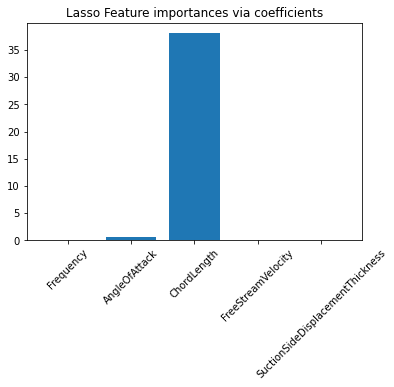

In [48]:
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)

fname = ["Frequency", "AngleOfAttack", "ChordLength","FreeStreamVelocity", "SuctionSideDisplacementThickness"]
feature_names = np.array(fname)
plt.bar(height=importance.reshape(5), x=feature_names)
plt.xticks(rotation = 45)
plt.title("Lasso Feature importances via coefficients")
plt.show()

In [49]:
lassocv = LassoCV(alphas = arange(0.01, 1, 0.01), cv = 5, max_iter = 100000)
LRModel = lassocv.fit(x_train, y_train)
LRModel.coef_

C:\Users\kllee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([-1.29567924e-03, -7.00016122e-01, -3.80701291e+01,  1.10162453e-01,
       -0.00000000e+00])

In [50]:
print('alpha: '+ str(LRModel.alpha_ ))
print("r_squared: " + str(LRModel.score(x_train,y_train)))

alpha: 0.01
r_squared: 0.48574877677896866


In [51]:
#Add Lasso Regression Predicted Values
Predictions['Lasso Regression'] = LRPred = LRModel.predict(x_test)

In [52]:
# Append RMSE for all the models
ModelNames.append('Lasso Reg')

# Add RMSE
RMSE = np.append(RMSE,mean_squared_error(y_test, LRPred, squared = False))

# Perceptron (Multi Layer Perceptron)

In [53]:
reg = MLPRegressor(hidden_layer_sizes=(64,32,64),activation="relu" ,random_state=42, max_iter=20000).fit(x_train, y_train)

C:\Users\kllee\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [54]:
Predictions['Perceptron Pred'] = MLPPred=reg.predict(x_test)
y_pred = MLPPred=reg.predict(x_test)

print("R Squared Score: ", (r2_score(y_pred, y_test)))
root_mean_squared_error = math.sqrt(mean_squared_error(y_test,y_pred))
print(f"Root Mean Square Error: {root_mean_squared_error}")
print(f'Adj_R-Squared: {1 - (1-reg.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)}')

R Squared Score:  -0.060952699931723586
Root Mean Square Error: 37.17230659960851
Adj_R-Squared: -27.4635580984261


In [55]:
# Append RMSE for all the models
ModelNames.append('Perceptron')

# Add RMSE
RMSE = np.append(RMSE,mean_squared_error(y_test, MLPPred, squared = False))

In [56]:
copy_pred = Predictions.copy()

# Comparing the predicted values

In [57]:
# retraining model without intercept for scalable rmse calculations
NewY = y["Scaled sound pressure level"].apply(lambda x:math.sqrt(x))
X_train, X_test, Y_train, Y_test = train_test_split(x, NewY, test_size = 0.2, random_state = 2)
TRModel_0 = sm.OLS(Y_train, X_train).fit()
TRPred_0 = TRModel_0.predict(X_test)
# Append RMSE for all the models
ModelNames.append('Transformed Reg: sqrt')

# Add RMSE
RMSE = np.append(RMSE, mean_squared_error(Y_test, TRPred_0, squared = False))

In [58]:
RMSEData = np.column_stack((ModelNames,RMSE.round(2)))
RMSEData = pd.DataFrame(RMSEData)
RMSEData.columns = ['Model Name', 'RMSE Score']
RMSEData.style.hide_index()

C:\Users\kllee\AppData\Local\Temp\ipykernel_11536\1893729398.py:4: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  RMSEData.style.hide_index()


Model Name,RMSE Score
Linear Reg,4.68
Symbolic Reg,6.98
Ridge Reg,6.15
Lasso Reg,5.09
Perceptron,37.17
Transformed Reg: sqrt,2.67


In [59]:
opred = Predictions.copy()
y_test2 = y_test.copy()
y_test2.reset_index(inplace = True)
Predictions.reset_index(inplace = True)
#Predictions['Actual Y'] = y_test2

<AxesSubplot:>

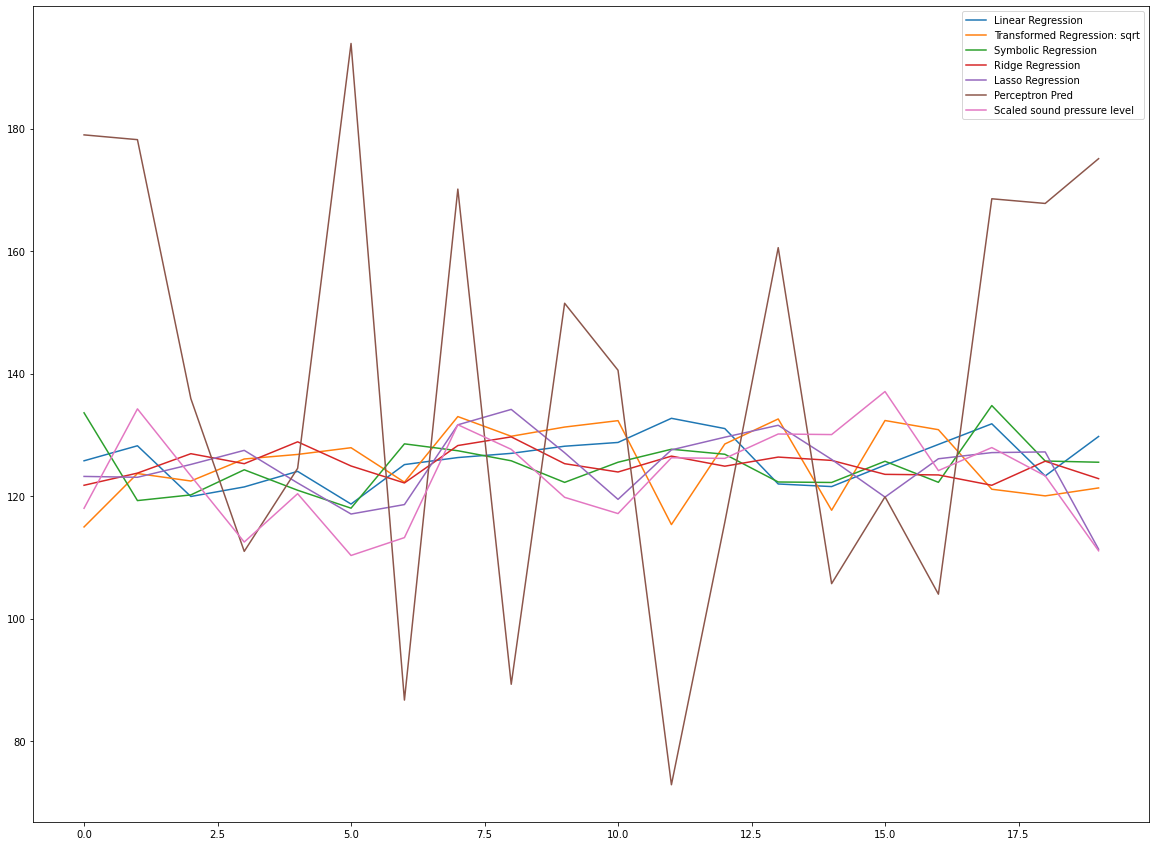

In [60]:
pred = pd.merge(Predictions, y_test2, how = "inner", left_index = True, right_index = True)
pred2 = pred.copy()
del pred["index_x"]
del pred["index_y"]
pred.reset_index(drop=True)[0:20].plot(figsize=(20,15))